### Set up

In [1]:
import pickle
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import stan
import pandas as pd
from scipy import stats
from scipy.special import softmax
from datetime import datetime
import time
import arviz as az
import json

In [2]:
# We take as workhorse N=500 with 10% signal in order to have 
# i) Small S/B ratio
# ii) At least ~50 signal events, and therefore some continuity in the True Positive Ratio variable

key = '10-08-2024.09.51UM' # N=500, pi = [0.3, 0.1, 0.6]  2k warm and sample <-- @N=500


In [4]:
# Import all results and variables into local variables

# Import posterior
chains_list = []
posterior = []
for chain in range(1,5):
#for chain in [1,3,4]:
    posterior.append(pd.read_csv('results/'+key+'-results_'+str(chain)+'.csv', comment="#", dtype=float))
    chains_list.append('results/'+key+'-results_'+str(chain)+'.csv')

posterior = pd.concat(posterior, ignore_index=True)

# Import used variables into local variables
with open('results/'+key+'_dictionary.pkl', 'rb') as f:
    mydict = pickle.load(f)
locals().update(mydict)  # this brings all variables in dictionary to local variables in this notebook

save = False

# Import the synthetic data used for the inference, as well as its true label for each data point
f = open('../unimode/'+key+'.json') 
data = json.load(f)
labeled_score = data['labeled_score']
# Observe:
# Class 0: cccc
# Class 1: bbbb
# Class 2: ccbb (any order)
labeled_score[:3]

[[2, 19, 13, 13, 16], [2, 18, 8, 19, 12], [0, 5, 5, 4, 13]]

In [6]:
# Let's check the S/B ratio and its absolute values
N_signal = len([x for x in labeled_score if x[0] == 1])
N_background = len([x for x in labeled_score if x[0] != 1])
N_signal, N_background

(49, 451)

## Summary

We aim to compare usual cut-based techniques with Bayesian techniques.  We'll compare both methods as classifiers.  Usually one is interested in classifying 4b events (e.g. hh > bbbb), 
hence we consider a classifier that selects 4b events.  The proper method for comparing classifiers is the ROC curve, hence we'll compute the ROC curves for both classifiers.  Moreover, a ROC curve needs the true labels, and in the real world we will not have them, henceforth in adition to the true ROC curves we'll compute the "what one would think is the ROC curve", since the difference between this estimated ROC curve and the true ROC curve is a good measurement of a potential bias when estimating a working point.

For the cut-based framework this is achieved by requiring that all four jets are b-tagged.  The working point for a jet to be considered b-tagged is going to be the variable that we'll vary to get the ROC curve in this case.

For the Bayesian framework the natural vaariable is the latent variable that indicates the probability of a given event to belong to the class 4b, $z_n$.  Varying a threshold on $z_n$ will allows us to construct the desired ROC curve in this framework

### ROC curve 1: Cut-based True on b-score

Demand all four jets to have b-score higher than a given threshold

In [7]:
roc1 = []
for threshold in range(100):
    tmp = [x for x in labeled_score if x[1] > threshold and x[2] > threshold and x[3] > threshold and x[4] > threshold]
    tmp_signal = len([x for x in tmp if x[0] == 1])
    tmp_background = len([x for x in tmp if x[0] != 1])
    roc1.append([tmp_signal/N_signal, tmp_background/N_background])  # Compute the TPR and FPR of the events passing the threshold     

In [8]:
auc1 = 0
for i in range(0, len(roc1)-1):
    auc1 += roc1[i][0] * ( roc1[i][1] - roc1[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc1 = np.round(auc1,3)

print('AUC1 =',auc1)

AUC1 = 0.869


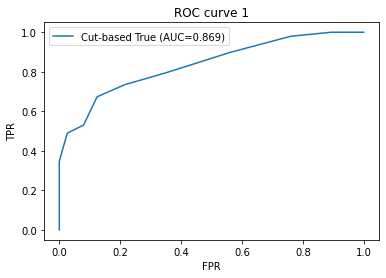

In [23]:
plt.plot([x[1] for x in roc1], [x[0] for x in roc1], label='Cut-based True (AUC='+str(auc1)+')')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve 1')
plt.legend()
plt.show()

### ROC curve 2: Cut-based estimated on prior belief on b-score

Use the prior curves on b-scores

In [13]:
# Variable used to construct the priors on the b-scores
theta_prior

[[4.5, 10.2], [4.5, 2.25]]

In [14]:
# Retrieve the prior b-score distributions for calculations
start1 = 0
stop1 = 1
step1 = (stop1 - start1)/(m-1)
midbins1 = [start1+(i+1/2)*step1 for i in range(0,m-1)]    
# Normalize the distributions dividing by the number of bins
prior_distribution = [ [midbins, (1/(m-1))*stats.beta.pdf(midbins1,theta_prior[0][0],theta_prior[0][1])], [midbins, (1/(m-1))*stats.beta.pdf(midbins1,theta_prior[1][0],theta_prior[1][1])] ]

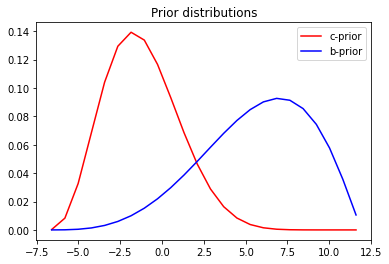

In [15]:
plt.plot(prior_distribution[0][0],prior_distribution[0][1], 'r-', label='c-prior')
plt.plot(prior_distribution[1][0],prior_distribution[1][1], 'b-', label='b-prior')
plt.title('Prior distributions')
plt.legend()
plt.show()

In [16]:
# Check normalization
sum(prior_distribution[0][1]),  sum(prior_distribution[0][1])

(0.9999818484995815, 0.9999818484995815)

In [17]:
#Using as threshold a given bin m_threshold,
#Probability of having a b-score larger than threshold for a c-jet:  
c_as_b = [sum(prior_distribution[0][1][m_threshold:]) for m_threshold in range(m)]
#Probability of having a b-score larger than threshold for a b-jet: 
b_as_b = [sum(prior_distribution[1][1][m_threshold:]) for m_threshold in range(m)]

In [18]:
# Therefore the probabilities for each one of the classes to be taken as the signal bbbb is:
bbbb_as_bbbb = [b_as_b[m_threshold]**4 for m_threshold in range(m)]
cccc_as_bbbb = [c_as_b[m_threshold]**4 for m_threshold in range(m)]
ccbb_as_bbbb = [c_as_b[m_threshold]**2 * b_as_b[m_threshold]**2 for m_threshold in range(m)] # Observe that we don't need to multiply by a combinatory factor, because all 4 should be above the threshold

In [19]:
# True Positive Ratio
# This is directly bbbb_as_bbbb as afunction of m_threshold
TPR = [bbbb_as_bbbb[m_threshold] for m_threshold in range(m)]

In [20]:
# False Positive Ratio
# This depends on the ratio of cccc and bbcc in the background, since each one of these
# has different FPR depending on m_threshold
#
# We consider the case in which the prior belief on fraction is totally unknown first 
# I.e. the background is 50% cccc and 50% bbcc
cccc_frac = 0.5
ccbb_frac = 0.5
FPR = [cccc_frac*cccc_as_bbbb[m_threshold]+ccbb_frac*ccbb_as_bbbb[m_threshold] for m_threshold in range(m)]
# Alternatively, you can use the true cccc and bbcc fractions in background
cccc_frac = pi[0] / (pi[0]+pi[2])
ccbb_frac = pi[2] / (pi[0]+pi[2])
FPR_correct_fractions = [cccc_frac*cccc_as_bbbb[m_threshold]+ccbb_frac*ccbb_as_bbbb[m_threshold] for m_threshold in range(m)]

In [21]:
roc2 = [ [TPR[m_threshold],FPR[m_threshold]] for m_threshold in range(m)]
roc2_correct_fractions = [ [TPR[m_threshold],FPR_correct_fractions[m_threshold]] for m_threshold in range(m)]

In [24]:
auc2 = 0
for i in range(0, len(roc2)-1):
    auc2 += roc2[i][0] * ( roc2[i][1] - roc2[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc2 = np.round(auc2,3)

print('AUC2 =',auc2)

AUC2 = 0.969


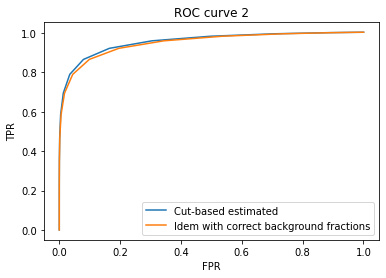

In [27]:
plt.plot([x[1] for x in roc2], [x[0] for x in roc2], label='Cut-based estimated')
plt.plot([x[1] for x in roc2_correct_fractions], [x[0] for x in roc2_correct_fractions], label='Idem with correct background fractions')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve 2')
plt.legend()
plt.show()

### ROC curve 3: Bayesian True using z_n

We must compute $z_n$ that is not computed in the posterir.  Actually what we can compute is

$ p(z_n|X) = \frac{p(X|z_n)\, p(z_n)}{p(X)} $

where

$p(X|z_n) = \int p(X|z_n, p_c, p_b)\, p(p_c) \ p(p_b) dp_c \, dp_b$

In [31]:
posterior

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a_j.1,a_j.2,a_j.3,...,p_b.15,p_b.16,p_b.17,p_b.18,p_b.19,p_b.20,p_b.21,p_b.22,p_b.23,p_b.24
0,-6056.10,0.996057,0.004365,9.0,803.0,1.0,6107.12,0.622688,0.881854,1.56234,...,0.067416,0.067748,0.088226,0.067375,0.059971,0.076047,0.106764,0.097285,0.070538,0.023772
1,-6052.02,0.931337,0.004365,10.0,1023.0,0.0,6101.82,0.293671,1.441070,1.30091,...,0.060956,0.066775,0.088326,0.056578,0.056685,0.090248,0.099348,0.085526,0.073025,0.020330
2,-6057.96,0.952199,0.004365,9.0,511.0,0.0,6098.12,0.851564,0.990391,1.08390,...,0.054132,0.060932,0.082711,0.066500,0.065249,0.098920,0.134028,0.097028,0.072141,0.019552
3,-6067.28,0.934077,0.004365,9.0,817.0,1.0,6106.37,0.422771,1.482480,1.07136,...,0.059177,0.061251,0.068333,0.048401,0.049654,0.082178,0.102379,0.085905,0.072754,0.024712
4,-6057.75,0.947082,0.004365,10.0,1023.0,0.0,6109.33,0.917642,0.939833,1.04031,...,0.094535,0.083152,0.059486,0.051137,0.055078,0.069803,0.106629,0.078848,0.062376,0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-6067.54,0.580800,0.005916,4.0,17.0,1.0,6118.85,1.334100,0.938462,1.21732,...,0.056321,0.058312,0.054552,0.054541,0.058860,0.077315,0.103709,0.098375,0.055843,0.028316
7996,-6066.87,0.654656,0.005916,2.0,4.0,1.0,6117.27,1.279520,0.934011,1.22186,...,0.072000,0.078164,0.065057,0.064076,0.060614,0.069268,0.087227,0.082877,0.046574,0.023915
7997,-6066.87,0.000000,0.005916,0.0,1.0,1.0,6114.15,1.279520,0.934011,1.22186,...,0.072000,0.078164,0.065057,0.064076,0.060614,0.069268,0.087227,0.082877,0.046574,0.023915
7998,-6067.41,0.731563,0.005916,2.0,4.0,1.0,6114.27,1.308050,0.919274,1.21801,...,0.068493,0.075255,0.065481,0.064957,0.065257,0.080297,0.104436,0.099015,0.055324,0.028753


In [141]:
def prob_x_given_b(i,bin):
    return posterior.iloc[i]['p_b.'+str(bin)]
def prob_x_given_c(i,bin):
    return posterior.iloc[i]['p_j.'+str(bin)]

In [34]:
# We will need the probability of z coming from the posterior knowledge to compute each
# p(z|x) = p(x|z) . p(z) / sum_zi (p(x|zi) . p(zi))
#
# We use p(z) = \int p(z) p(p(z)) dp(z) , where the weighted integral is performed by summing on the posterior samples
pz0 = 0  
pz1 = 0
pz2 = 0
for i in range(len(posterior)):
    # Attention:
    # In the .stan files there is mismatch and the theta correspond to the following classes:
    # theta.1: cccc;   theta.2: ccbb;   theta.3: bbbb
    # Hence I correct in the following lines to keep the notation that the classes are cccc, bbbb and ccbb, respectively
    pz0 += posterior.iloc[i]['theta.1']
    pz2 += posterior.iloc[i]['theta.2']
    pz1 += posterior.iloc[i]['theta.3']

pz0 = pz0/len(posterior)
pz1 = pz1/len(posterior)
pz2 = pz2/len(posterior)
pz0, pz1, pz2, pz0+pz1+pz2

(0.28017143397500116, 0.08606595623500028, 0.633762610625, 1.0000000008350014)

In [37]:
# Let's check the agreement between true-expected and estimated number of events in each class
print(pi)
print(pz0,pz1,pz2)

[0.3, 0.1, 0.6]
0.28017143397500116 0.08606595623500028 0.633762610625


In [158]:
np.random.randint(10)

3

In [163]:
def prob_x_given_z(x):
    p0 = 0 # cccc
    p1 = 0 # bbbb
    p2 = 0 # ccbb
    N_samples = int(len(posterior)/10)
    # z==0
    for k in range(N_samples):
        i = np.random.randint(len(posterior))
        # we are numerically integrating in this loop
        p0 += prob_x_given_c(i,x[0])*prob_x_given_c(i,x[1])*prob_x_given_c(i,x[2])*prob_x_given_c(i,x[3])
        p1 += prob_x_given_b(i,x[0])*prob_x_given_b(i,x[1])*prob_x_given_b(i,x[2])*prob_x_given_b(i,x[3])
        p2 += (1/6)*(prob_x_given_c(i,x[0])*prob_x_given_c(i,x[1])*prob_x_given_b(i,x[2])*prob_x_given_b(i,x[3])+
                     prob_x_given_c(i,x[0])*prob_x_given_b(i,x[1])*prob_x_given_c(i,x[2])*prob_x_given_b(i,x[3])+
                     prob_x_given_c(i,x[0])*prob_x_given_b(i,x[1])*prob_x_given_b(i,x[2])*prob_x_given_c(i,x[3])+
                     prob_x_given_b(i,x[0])*prob_x_given_c(i,x[1])*prob_x_given_c(i,x[2])*prob_x_given_b(i,x[3])+
                     prob_x_given_b(i,x[0])*prob_x_given_c(i,x[1])*prob_x_given_b(i,x[2])*prob_x_given_c(i,x[3])+
                     prob_x_given_b(i,x[0])*prob_x_given_b(i,x[1])*prob_x_given_c(i,x[2])*prob_x_given_c(i,x[3]))
        
    return [p0/N_samples,p1/N_samples,p2/N_samples]

def prob_z_given_x(x):
    tmp = prob_x_given_z(x)
    tot = tmp[0]*pz0 + tmp[1]*pz1 + tmp[2]*pz2 # sum of three probabilities to normalize with this
    return [tmp[0]*pz0/tot, tmp[1]*pz1/tot, tmp[2]*pz2/tot]


In [361]:
%%time
out = []
#out = out.values.tolist() # convert dataframe to list
for i in range(len(out),len(labeled_score)):
#for i in range(100):    
    if i % 10 == 0 : print(i)
    t = prob_z_given_x(labeled_score[i][1:])
    out.append([i]+t+labeled_score[i])
    print(out[-1])

0
[0, 0.023033863377024587, 0.2928588518455923, 0.684107284777383, 2, 19, 13, 13, 16]
[1, 0.018841593632138484, 0.05841579568084718, 0.9227426106870145, 2, 18, 8, 19, 12]
[2, 0.8755029373423069, 0.0009418349197942522, 0.12355522773789879, 0, 5, 5, 4, 13]
[3, 0.24150996645604142, 0.034136932013259826, 0.7243531015306989, 0, 13, 16, 12, 9]
[4, 0.5772177837798914, 0.002792138093192004, 0.41999007812691663, 0, 6, 11, 6, 15]
[5, 0.6085294392657538, 0.005844536136710254, 0.38562602459753603, 2, 13, 6, 12, 11]
[6, 0.01839145042749966, 0.20665494802411347, 0.7749536015483869, 2, 10, 15, 20, 15]
[7, 0.11778218507577617, 0.12230521637702939, 0.7599125985471944, 2, 16, 12, 11, 15]
[8, 0.8787958673748318, 0.000626924021546413, 0.12057720860362173, 0, 10, 8, 5, 11]
[9, 0.06552611403576998, 0.045748412228441976, 0.888725473735788, 0, 11, 11, 21, 10]
10
[10, 0.14150838373762276, 0.006075558958352798, 0.8524160573040244, 2, 6, 20, 11, 6]
[11, 0.0058158215751322965, 0.031897424444320525, 0.962286753980

In [365]:
out = pd.DataFrame(out, columns = ['event','p(0)','p(1)','p(2)','true_class','b-score_1','b-score_2','b-score_3','b-score_4'])
len(out)

500

In [175]:
#out.to_csv('results/p_z_x.'+key+'.with_pz.csv')
out = pd.read_csv('results/p_z_x.'+key+'.with_pz.csv')

In [176]:
out[-10:]

,Unnamed: 0,event,p(0),p(1),p(2),true_class,b-score_1,b-score_2,b-score_3,b-score_4
490,490,490,0.102731,0.009111,0.888158,2,11,9,7,21
491,491,491,0.039805,0.041575,0.918620,2,7,13,14,23
492,492,492,0.005021,0.046943,0.948035,2,11,20,8,21
493,493,493,0.671118,0.002315,0.326567,0,13,6,13,5
494,494,494,0.264790,0.007232,0.727978,2,6,16,8,14
495,495,495,0.876248,0.000786,0.122967,0,13,5,6,4
496,496,496,0.026836,0.014295,0.958869,2,9,5,20,16
497,497,497,0.060585,0.015604,0.923812,2,20,14,9,8
498,498,498,0.064646,0.009183,0.926171,2,6,5,14,20
499,499,499,0.029756,0.010269,0.959975,2,19,7,17,7


In [177]:
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
for i in range(len(out)):
    t = list(out.iloc[i][['p(0)','p(1)','p(2)']])
    expected = int(t.index(max(t)))
    true_class = int(out.iloc[i]['true_class'])
    confusion_matrix[true_class][expected] += 1/len(out)

In [178]:
confusion_matrix # no p(z) in Bayes

[[0.2440000000000002, 0, 0.06600000000000004],
 [0, 0.04600000000000003, 0.05200000000000003],
 [0.03800000000000002, 0.006, 0.5480000000000004]]

In [179]:
N0_true = len(out[out['true_class']==0])
N1_true = len(out[out['true_class']==1])
N2_true = len(out[out['true_class']==2])
N = len(out)
print(N0_true, N1_true, N2_true)
print(N0_true/N, N1_true/N, N2_true/N)

155 49 296
0.31 0.098 0.592


In [180]:
roc3 = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out[ out['p(1)'] > zi_threshold ]
    N0_in_tmp = len(tmp[tmp['true_class']==0])  # cccc
    N1_in_tmp = len(tmp[tmp['true_class']==1])  # bbbb
    N2_in_tmp = len(tmp[tmp['true_class']==2])  # ccbb
    tpr = N1_in_tmp / N1_true
    fpr = ( N0_in_tmp + N2_in_tmp ) / ( N0_true + N2_true ) 
    roc3.append( [ tpr, fpr] )

auc3 = 0
for i in range(0, len(roc3)-1):
    auc3 += roc3[i][0] * ( roc3[i][1] - roc3[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc3 = np.round(auc3,3)

print('AUC3 =',auc3)

AUC3 = 0.911


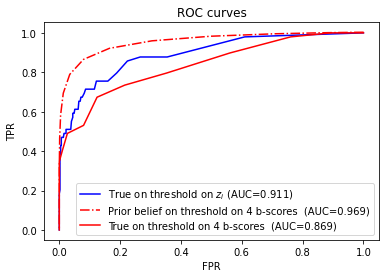

In [181]:
plt.plot([x[1] for x in roc3], [x[0] for x in roc3], 'b', label='True on threshold on $z_i$ (AUC='+str(auc3)+')')
plt.plot([x[1] for x in roc2], [x[0] for x in roc2], 'r-.', label='Prior belief on threshold on 4 b-scores  (AUC='+str(auc2)+')')
plt.plot([x[1] for x in roc1], [x[0] for x in roc1], 'r', label='True on threshold on 4 b-scores  (AUC='+str(auc1)+')')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.show()

In [182]:
roc3_class0 = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out[ out['p(0)'] > zi_threshold ]
    N0_in_tmp = len(tmp[tmp['true_class']==0])  # cccc
    N1_in_tmp = len(tmp[tmp['true_class']==1])  # bbbb
    N2_in_tmp = len(tmp[tmp['true_class']==2])  # ccbb
    tpr = N0_in_tmp / N0_true
    fpr = ( N1_in_tmp + N2_in_tmp ) / ( N1_true + N2_true ) 
    roc3_class0.append( [ tpr, fpr] )

roc3_class2 = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out[ out['p(2)'] > zi_threshold ]
    N0_in_tmp = len(tmp[tmp['true_class']==0])  # cccc
    N1_in_tmp = len(tmp[tmp['true_class']==1])  # bbbb
    N2_in_tmp = len(tmp[tmp['true_class']==2])  # ccbb
    tpr = N2_in_tmp / N2_true
    fpr = ( N1_in_tmp + N0_in_tmp ) / ( N1_true + N0_true ) 
    roc3_class2.append( [ tpr, fpr] )

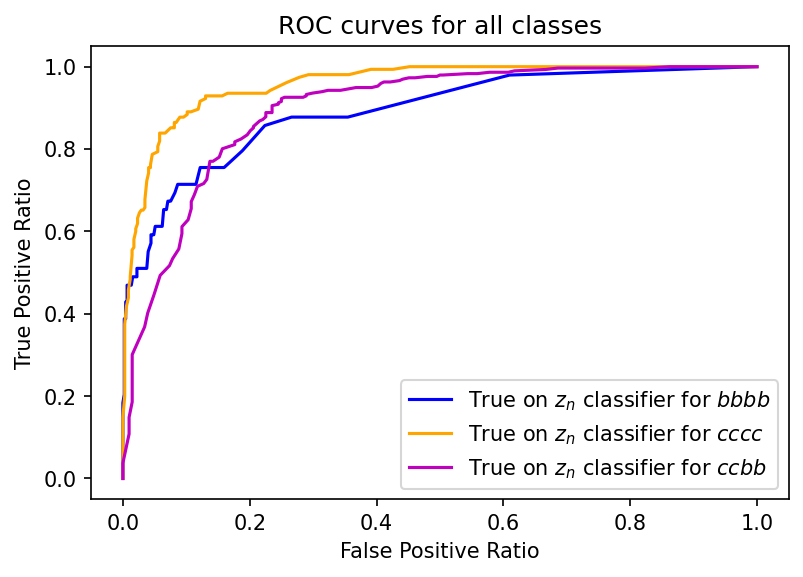

In [197]:
plt.figure(dpi=150)
plt.plot([x[1] for x in roc3], [x[0] for x in roc3], 'b', label='True on $z_n$ classifier for $bbbb$')
plt.plot([x[1] for x in roc3_class0], [x[0] for x in roc3_class0], color='orange', label='True on $z_n$ classifier for $cccc$')
plt.plot([x[1] for x in roc3_class2], [x[0] for x in roc3_class2], 'm-', label='True on $z_n$ classifier for $ccbb$')
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC curves for all classes')
plt.legend()
plt.savefig('figs/roc2.png')
plt.show()

### Estimated ROC using Bayes: 

Instead of having the true number of events of each class, in total and in the selected sample, we'll use the inferred number of events in each one

#### 1) using p(z) on data and estimating labels with p(z) [[potential bias then!]]

In [74]:
N0_inferred = sum(out['p(0)'])
N1_inferred = sum(out['p(1)'])
N2_inferred = sum(out['p(2)'])
Ntot = N0_inferred + N1_inferred + N2_inferred
print(N0_inferred/Ntot, N1_inferred/Ntot, N2_inferred/Ntot)

0.27911194228852887 0.08294631534929717 0.637941742362174


In [75]:
N0_inferred = sum(out['p(0)'])
N1_inferred = sum(out['p(1)'])
N2_inferred = sum(out['p(2)'])
Ntot = N0_inferred + N1_inferred + N2_inferred
print(N0_inferred/Ntot, N1_inferred/Ntot, N2_inferred/Ntot)

0.27911194228852887 0.08294631534929717 0.637941742362174


In [76]:
print(N0_true, N1_true, N2_true)
Ntot = N0_true+N1_true+N2_true
print(N0_true/Ntot, N1_true/Ntot, N2_true/Ntot)

155 49 296
0.31 0.098 0.592


In [77]:
roc3_inferred = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out[ out['p(1)'] > zi_threshold ]
    N0_inferred_in_tmp = sum(tmp['p(0)'])  # cccc
    N1_inferred_in_tmp = sum(tmp['p(1)'])  # bbbb
    N2_inferred_in_tmp = sum(tmp['p(2)'])  # ccbb
    tpr = N1_inferred_in_tmp / N1_inferred
    fpr = ( N0_inferred_in_tmp + N2_inferred_in_tmp ) / ( N0_inferred + N2_inferred ) 
    roc3_inferred.append( [ tpr, fpr] )

auc3_inferred = 0
for i in range(0, len(roc3_inferred)-1):
    auc3_inferred += roc3_inferred[i][0] * ( roc3_inferred[i][1] - roc3_inferred[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc3_inferred = np.round(auc3_inferred,3)

print('AUC3_inferred =',auc3_inferred)

AUC3_inferred = 0.936


Manu: 

- if you select with z_n and then estimate events also with sum(z_n), then you may bias to have better efficiency
- background becomes a validation tool, instead of an issue

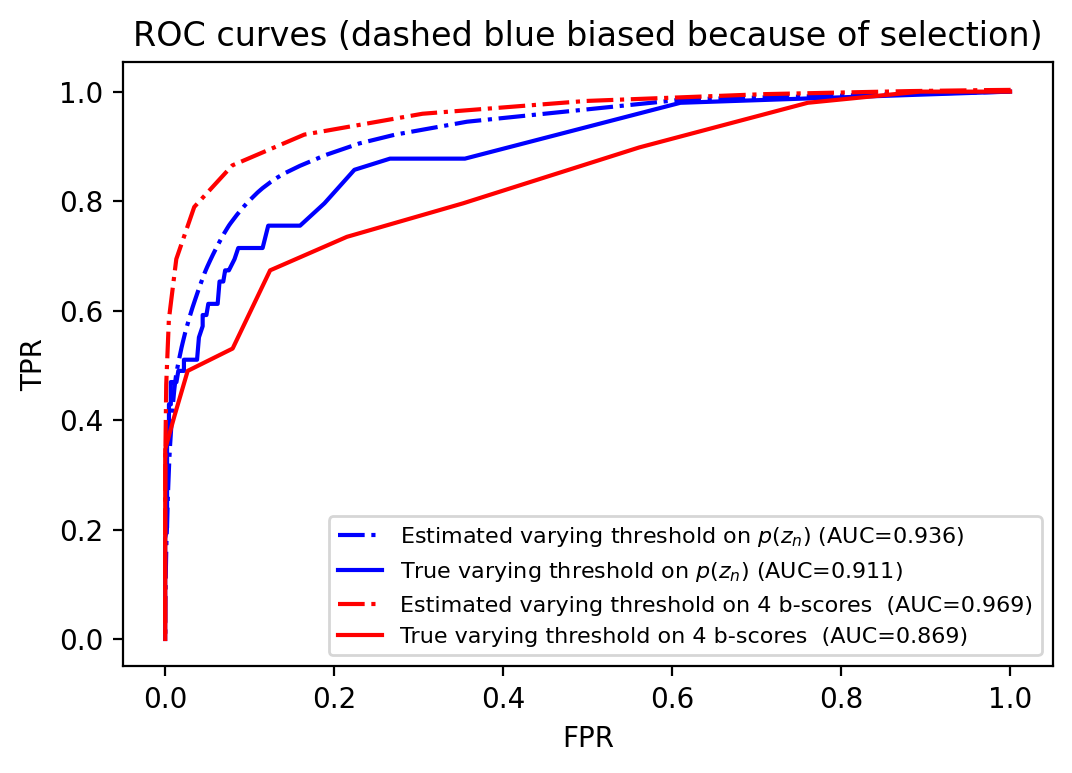

In [199]:
plt.figure(dpi=200)
plt.plot([x[1] for x in roc3_inferred], [x[0] for x in roc3_inferred], 'b-.', label='Estimated varying threshold on $p(z_n)$ (AUC='+str(auc3_inferred)+')')
plt.plot([x[1] for x in roc3], [x[0] for x in roc3], 'b', label='True varying threshold on $p(z_n)$ (AUC='+str(auc3)+')')
plt.plot([x[1] for x in roc2], [x[0] for x in roc2], 'r-.', label='Estimated varying threshold on 4 b-scores  (AUC='+str(auc2)+')')
plt.plot([x[1] for x in roc1], [x[0] for x in roc1], 'r', label='True varying threshold on 4 b-scores  (AUC='+str(auc1)+')')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves (dashed blue biased because of selection)')
plt.legend(loc='lower right', fontsize=8)
plt.show()

#### 2) using p(z) on synthetic data in which we have the labels

In [79]:
posterior[:2]

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a_j.1,a_j.2,a_j.3,...,p_b.15,p_b.16,p_b.17,p_b.18,p_b.19,p_b.20,p_b.21,p_b.22,p_b.23,p_b.24
0,-6056.10,0.996057,0.004365,9.0,803.0,1.0,6107.12,0.622688,0.881854,1.56234,...,0.067416,0.067748,0.088226,0.067375,0.059971,0.076047,0.106764,0.097285,0.070538,0.023772
1,-6052.02,0.931337,0.004365,10.0,1023.0,0.0,6101.82,0.293671,1.441070,1.30091,...,0.060956,0.066775,0.088326,0.056578,0.056685,0.090248,0.099348,0.085526,0.073025,0.020330


In [81]:
N

500

In [86]:
posterior.iloc[3]['theta.2']

0.653445

In [160]:
# We generate pseudo-data from out posterior knowledge
N = 1000
np.random.seed(100)
features = 4
X = []  # 
for n in range(N): 
    # class0 0000
    # class1 1111
    # class2 0011 (any order)
    myclass = list( stats.multinomial.rvs(n=1, p=[posterior.iloc[n]['theta.1'],posterior.iloc[n]['theta.3'],posterior.iloc[n]['theta.2']]) ).index(1) # Observe that 2 <--> 3 because the stan script has a mismatch
    # get the pjs and pbs curves from the nth posterior sample
    pjs = posterior.iloc[n][['p_j.'+str(i) for i in range(1,25)]].values
    pbs = posterior.iloc[n][['p_b.'+str(i) for i in range(1,25)]].values
    totj = sum(pjs)
    totb = sum(pbs)
    pjs = [pjs[i]/totj for i in range(len(pjs))]
    pbs = [pbs[i]/totb for i in range(len(pbs))]    
    if myclass == 0:        
        tmp = list(np.random.choice(range(1,m), size = features, p = pjs) ) 
        X.append([myclass]+ tmp)     
    if myclass == 1:        
        tmp = list(np.random.choice(range(1,m), size = features, p = pbs) ) 
        X.append([myclass]+ tmp)     
    if myclass == 2:  # if class is 0011, then I should choose at random in which order are the jets, but always being 2 X c0 and 2 x c1
        z = np.random.randint(6)
        c01, c02, c11, c12 = list(np.random.choice(range(1,m), size = 1, p = pjs))[0], list(np.random.choice(range(1,m), size = 1, p = pjs))[0], list(np.random.choice(range(1,m), size = 1, p = pbs))[0], list(np.random.choice(range(1,m), size = 1, p = pbs))[0] 
        sampled = [ [c01,c02,c11,c12], [c01,c11,c02,c12], [c01,c11,c12,c02], [c11,c01,c02,c12],  [c11,c01,c12,c02], [c11,c12,c01,c02] ]
        X.append([myclass]+sampled[z])            
X=np.array(X)        
X0 = pd.DataFrame(X, columns=['class','xn0','xn1','xn2','xn3'])

In [161]:
pz0 = len(X0[X0['class']==0])/N
pz1 = len(X0[X0['class']==1])/N
pz2 = len(X0[X0['class']==2])/N
pz0, pz1, pz2

(0.263, 0.093, 0.644)

In [165]:
%%time
out2 = []
#out = out.values.tolist() # convert dataframe to list
for q in range(len(X0)):
#for i in range(100):        
    t = prob_z_given_x(list(X0.iloc[q][['xn0','xn1','xn2','xn3']].values))
    out2.append([q]+t+list(X0.iloc[q].values))
    if q % 10 == 0 : 
        print(q)
        print(out2[-1])

0
[0, 0.5579592009276259, 0.0036850501527291237, 0.4383557489196451, 2, 6, 6, 13, 14]
10
[10, 0.0035270905482934897, 0.2107679587240115, 0.785704950727695, 2, 21, 11, 12, 22]
20
[20, 0.8179618292479076, 0.0020919963998392668, 0.17994617435225307, 0, 10, 11, 8, 10]
30
[30, 0.16458298187226883, 0.012205587756705754, 0.8232114303710254, 2, 10, 7, 11, 19]
40
[40, 0.0023478140278551927, 0.48084727922342047, 0.5168049067487244, 2, 13, 21, 21, 14]
50
[50, 0.015484219577273394, 0.029358872718328627, 0.9551569077043979, 2, 17, 3, 20, 5]
60
[60, 0.23004565150816442, 0.022492876106749934, 0.7474614723850856, 2, 13, 12, 16, 7]
70
[70, 0.06601462031069541, 0.02503182832302001, 0.9089535513662846, 2, 12, 12, 6, 20]
80
[80, 0.016322756190902916, 0.08495837603755835, 0.8987188677715388, 2, 23, 16, 14, 7]
90
[90, 0.9244224696605879, 0.00034043943651067775, 0.0752370909029014, 0, 7, 5, 11, 5]
100
[100, 0.48461949481116323, 0.006951082916188732, 0.508429422272648, 2, 7, 11, 10, 15]
110
[110, 0.0291696776

In [166]:
out2 = pd.DataFrame(out2, columns = ['event','p(0)','p(1)','p(2)','true_class','b-score_1','b-score_2','b-score_3','b-score_4'])
len(out2)

1000

In [167]:
out2.to_csv('results/p_z_x.'+key+'.with_pz.synthetic-data.csv')

In [168]:
out2[-10:]

,event,p(0),p(1),p(2),true_class,b-score_1,b-score_2,b-score_3,b-score_4
990,990,0.035678,0.032164,0.932158,2,19,6,11,16
991,991,0.013290,0.049397,0.937312,2,17,7,12,23
992,992,0.000888,0.727653,0.271459,1,23,11,21,19
993,993,0.858541,0.000904,0.140555,0,9,6,11,10
994,994,0.016499,0.082976,0.900525,2,7,23,14,16
995,995,0.061073,0.019848,0.919079,2,13,9,9,22
996,996,0.333654,0.031278,0.635069,0,14,12,14,9
997,997,0.032711,0.019897,0.947392,2,9,15,23,4
998,998,0.004164,0.012522,0.983314,2,6,21,5,21
999,999,0.769106,0.001958,0.228935,0,9,12,7,11


In [169]:
confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
for i in range(len(out2)):
    t = list(out2.iloc[i][['p(0)','p(1)','p(2)']])
    expected = int(t.index(max(t)))
    true_class = int(out2.iloc[i]['true_class'])
    confusion_matrix[true_class][expected] += 1/len(out2)

In [170]:
confusion_matrix # no p(z) in Bayes

[[0.18700000000000014, 0, 0.07600000000000005],
 [0, 0.04300000000000003, 0.05000000000000004],
 [0.07700000000000005, 0.012000000000000004, 0.5550000000000004]]

In [171]:
N0_true = len(out2[out2['true_class']==0])
N1_true = len(out2[out2['true_class']==1])
N2_true = len(out2[out2['true_class']==2])
N = len(out2)
print(N0_true, N1_true, N2_true)
print(N0_true/N, N1_true/N, N2_true/N)

263 93 644
0.263 0.093 0.644


In [172]:
roc4 = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out2[ out2['p(1)'] > zi_threshold ]
    N0_in_tmp = len(tmp[tmp['true_class']==0])  # cccc
    N1_in_tmp = len(tmp[tmp['true_class']==1])  # bbbb
    N2_in_tmp = len(tmp[tmp['true_class']==2])  # ccbb
    tpr = N1_in_tmp / N1_true
    fpr = ( N0_in_tmp + N2_in_tmp ) / ( N0_true + N2_true ) 
    roc4.append( [ tpr, fpr] )

auc4 = 0
for i in range(0, len(roc4)-1):
    auc4 += roc4[i][0] * ( roc4[i][1] - roc4[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc4 = np.round(auc4,3)

print('AUC4 =',auc4)

AUC4 = 0.935


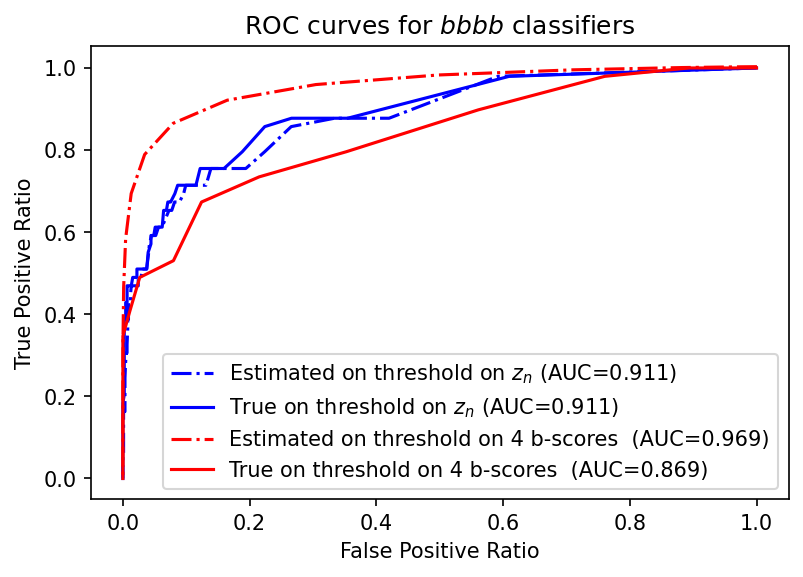

In [193]:
plt.figure(dpi=150)
plt.plot([x[1] for x in roc4], [x[0] for x in roc3], 'b-.', label='Estimated on threshold on $z_n$ (AUC='+str(auc3)+')')
plt.plot([x[1] for x in roc3], [x[0] for x in roc3], 'b', label='True on threshold on $z_n$ (AUC='+str(auc3)+')')
plt.plot([x[1] for x in roc2], [x[0] for x in roc2], 'r-.', label='Estimated on threshold on 4 b-scores  (AUC='+str(auc2)+')')
plt.plot([x[1] for x in roc1], [x[0] for x in roc1], 'r', label='True on threshold on 4 b-scores  (AUC='+str(auc1)+')')
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC curves for $bbbb$ classifiers')
plt.legend()
plt.savefig('figs/roc1.png')
plt.show()

#### Alternative 2

count events to a class only when that class has the largest probability

In [380]:
# It is weird the disagreement between N_inferred and N_true by summing probabbilities
# Let's try by threshold

N0_inferred2 = 0 
N1_inferred2 = 0 
N2_inferred2 = 0 
for i in range(len(out)):
    if out.iloc[i]['p(0)'] > out.iloc[i]['p(1)'] and out.iloc[i]['p(0)'] > out.iloc[i]['p(2)']:
        N0_inferred2 += 1
    if out.iloc[i]['p(1)'] > out.iloc[i]['p(0)'] and out.iloc[i]['p(1)'] > out.iloc[i]['p(2)']:
        N1_inferred2 += 1
    if out.iloc[i]['p(2)'] > out.iloc[i]['p(0)'] and out.iloc[i]['p(2)'] > out.iloc[i]['p(1)']:
        N2_inferred2 += 1        

Ntot = N0_inferred2 + N1_inferred2 + N2_inferred2
print(N0_inferred2/Ntot, N1_inferred2/Ntot, N2_inferred2/Ntot)

0.282 0.052 0.666


In [381]:
roc3_inferred2 = []
for zi_threshold in np.linspace(0,1,100):
    tmp = out[ out['p(1)'] > zi_threshold ]
    N0_inferred2_in_tmp = 0 
    N1_inferred2_in_tmp = 0 
    N2_inferred2_in_tmp = 0     
    for i in range(len(tmp)):
        if tmp.iloc[i]['p(0)'] > tmp.iloc[i]['p(1)'] and tmp.iloc[i]['p(0)'] > tmp.iloc[i]['p(2)']:
            N0_inferred2_in_tmp += 1
        if out.iloc[i]['p(1)'] > tmp.iloc[i]['p(0)'] and tmp.iloc[i]['p(1)'] > tmp.iloc[i]['p(2)']:
            N1_inferred2_in_tmp += 1
        if tmp.iloc[i]['p(2)'] > tmp.iloc[i]['p(0)'] and tmp.iloc[i]['p(2)'] > tmp.iloc[i]['p(1)']:
            N2_inferred2_in_tmp += 1    
    tpr = N1_inferred2_in_tmp / N1_inferred2
    fpr = ( N0_inferred2_in_tmp + N2_inferred2_in_tmp ) / ( N0_inferred2 + N2_inferred2 ) 
    roc3_inferred2.append( [ tpr, fpr] )

auc3_inferred2 = 0
for i in range(0, len(roc3_inferred2)-1):
    auc3_inferred2 += roc3_inferred2[i][0] * ( roc3_inferred2[i][1] - roc3_inferred2[i+1][1] )  # recall that it goes from larger fpt to lower fpr
auc3_inferred2 = np.round(auc3_inferred2,3)

print('AUC3_inferred2 =',auc3_inferred2)

AUC3_inferred2 = 0.947


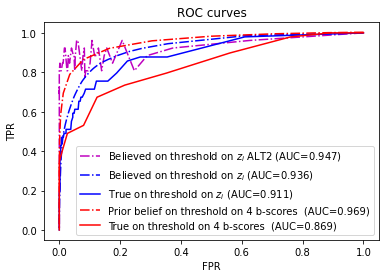

In [382]:
plt.plot([x[1] for x in roc3_inferred2], [x[0] for x in roc3_inferred2], 'm-.', label='Believed on threshold on $z_i$ ALT2 (AUC='+str(auc3_inferred2)+')')
plt.plot([x[1] for x in roc3_inferred], [x[0] for x in roc3_inferred], 'b-.', label='Believed on threshold on $z_i$ (AUC='+str(auc3_inferred)+')')
plt.plot([x[1] for x in roc3], [x[0] for x in roc3], 'b', label='True on threshold on $z_i$ (AUC='+str(auc3)+')')
plt.plot([x[1] for x in roc2], [x[0] for x in roc2], 'r-.', label='Prior belief on threshold on 4 b-scores  (AUC='+str(auc2)+')')
plt.plot([x[1] for x in roc1], [x[0] for x in roc1], 'r', label='True on threshold on 4 b-scores  (AUC='+str(auc1)+')')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.legend()
plt.show()

#### Alternative 3

Same as alternative 1, but with only 2 classes: signal and background

In [337]:
# It is weird the disagreement between N_inferred and N_true by summing probabbilities
# Let's try by threshold

Ns_inferred = 0 
Nb_inferred = 0 
for i in range(len(out)):
    if out.iloc[i]['p(1)'] > out.iloc[i]['p(0)'] + out.iloc[i]['p(2)']:
        Ns_inferred += 1
    else:
        Nb_inferred += 1
    
Ntot = Ns_inferred + Nb_inferred
print(Ns_inferred/Ntot, Nb_inferred/Ntot)

0.156 0.844
